In [1]:
import pandas as pd
from collections import defaultdict
import os
import pickle
import seaborn as sns
sns.set_context('paper', font_scale=0.73)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy
from statsmodels.stats.power import TTestIndPower
from collections import Counter

In [2]:
PUBLIC_RELEASE_PATH = "C:/Users/t-johnnywei/Documents/GitHub/ToShipOrNotToShip\public_release"

In [3]:
def load_data(use_cache=True):
    cache_filename = "data.pickle"
    data = defaultdict(dict)
    if use_cache and os.path.isfile(cache_filename):
        with open(cache_filename, 'rb') as handle:
            data = pickle.load(handle)
    else:
        _, campaigns_list, _ = next(os.walk(PUBLIC_RELEASE_PATH))
        counter = 1
        for campaign in campaigns_list:
            if campaign not in data:
                data[campaign] = defaultdict(dict)
            for _, _, systems_list in os.walk(f"{PUBLIC_RELEASE_PATH}/{campaign}"):
                for system in systems_list:
                    if system not in data[campaign]:
                        data[campaign][system] = defaultdict(dict)
                    print(f"Loading {counter}/{len(campaigns_list)} campaign")
                    xls = pd.ExcelFile(f"{PUBLIC_RELEASE_PATH}/{campaign}/{system}")
                    for datatype in xls.sheet_names:
                        if datatype in ["hum_annotations",
                                        "full_test"]:
                            data[campaign][system][datatype] = pd.read_excel(
                                xls, datatype)
                        else:
                            df = pd.read_excel(xls, datatype)
                            # transform to dictionary
                            df_dict = df.set_index("Unnamed: 0").transpose()
                            df_dict = df_dict.iloc[0].to_dict()
                            data[campaign][system][datatype] = df_dict
                counter += 1

        # save the cache data
        if use_cache:
            with open(cache_filename, 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Annotated data loaded")
    return data

In [4]:
data = load_data()

Annotated data loaded


In [5]:
def pairs():
    for (k, v) in data.items():
        for i, j in itertools.combinations(v, 2):
            yield (v[i]['hum_annotations'], v[j]['hum_annotations'])

In [6]:
# get language pairs
st = [('ENU', 'FRA')]

In [7]:
def mde(sorted_results):
    p_test = 0.05
    threshold = 0.95
    sig, insig = 0, 0
    last_diff = 0
    for diff, pvalue in sorted_results:
        if pvalue < 0.05:
            sig += 1
        else:
            insig += 1

        if sig / (sig + insig) < threshold:
            return last_diff, sig, insig
        last_diff = diff
        
    # no mde found
    return None, sig, insig

In [8]:
lp_pairs = []
for i, j in pairs():
    s = i['Source'].unique()
    t = i['Target'].unique()

    if st[0][0] == s and st[0][1] == t:
        lp_pairs.append((i, j))
  
results = []
for df1, df2 in lp_pairs:
    diff = np.abs(df1['Score'].mean() - df2['Score'].mean())
    s, pvalue = scipy.stats.mannwhitneyu(df1['Score'], df2['Score'])
    results.append((diff, pvalue))
results = np.array(results)

order = (-results[:, 0]).argsort()
sorted_results = results[order]
obs_mde, sig, insig = mde(sorted_results)

# get 25th percentile
q_diff = sorted_results[int(len(sorted_results) * 0.5), 0]

In [9]:
obs_mde

3.8047808764940214

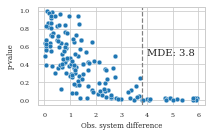

In [23]:
plt.figure(figsize=(3, 1.8))
g = sns.scatterplot(x=results[:,0], y=results[:,1])
g.axvline(obs_mde, linestyle='--', color='grey')
plt.text(4, 0.5, 'MDE: %.1f' % obs_mde, size=10)
g.set(xlabel='Obs. system difference', ylabel='p-value')
plt.savefig('enu-fra_mde.pdf', bbox_inches='tight')